In [30]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cv2

import requests
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pylab as pylab
import cv2
import math
import torch
import matplotlib
import matplotlib.pyplot as plt
import json
import matplotlib.gridspec as gridspec
from itertools import chain
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import matplotlib.colorbar as colorbar
import h5py

from torchvision import transforms as T

from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from maskrcnn_benchmark import layers as L
from maskrcnn_benchmark.utils import cv2_util

import numpy as np
import matplotlib.pyplot as plt
from maskrcnn_benchmark.structures.keypoint import PersonKeypoints, BeeKeypoints, FlyKeypoints

import requests
from io import BytesIO
from PIL import Image
import numpy as np
from maskrcnn_benchmark.utils import cv2_util
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from moviepy.editor import VideoFileClip

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20*1.5, 12*1.5

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
from demo.predictor import COCODemo


from moviepy.editor import VideoFileClip

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
#from predictor import COCODemo

In [31]:
def load(img_path):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    pil_image = Image.open(img_path).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def load_video(video_path,frame_id=[0]):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    video_clip = VideoFileClip(video_path)
    if frame_id is None:
        nframes = int(video_clip.fps * video_clip.duration)
        frame_id = range(nframes)
    images = []
    for i in frame_id:
        image = video_clip.get_frame(i/video_clip.fps)
        # convert to BGR format
        image = np.array(image)[:, :, [2, 1, 0]]
        images += [image]
    video_clip.close()
    
    return images

def imshow(img):
    plt.gca().invert_yaxis()
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# num keypoints per animal, heatmap
def calculate_peaks(numparts, heatmap_avg):
    score = np.ones((numparts,)) * 0.000001
    all_peaks = []
    peak_counter = 0
    if len(score) < numparts:
        score = score[:numparts]
        print("score", score)
        ##logger.ERROR(‘Not enough scores provided for number of parts’)
        # return
    # threshold_detection = params[‘thre1’]
    # tic_localmax=time.time()
    for part in range(numparts):
        map_ori = heatmap_avg[part, :, :]
        map = map_ori
        map_left = np.zeros(map.shape)
        map_left[1:, :] = map[:-1, :]
        map_right = np.zeros(map.shape)
        map_right[:-1, :] = map[1:, :]
        map_up = np.zeros(map.shape)
        map_up[:, 1:] = map[:, :-1]
        map_down = np.zeros(map.shape)
        map_down[:, :-1] = map[:, 1:]
        #peaks_binary = np.logical_and(np.logical_and(np.logical_and(map >= map_left, map >= map_right),
                                                     #np.logical_and(map >= map_up, map >= map_down)), map > score[part])
        peaks_binary = (sigmoid_v(map_ori) > .2)
        #print("pb shap", np.shape(peaks_binary))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
        peaks_with_score_and_id = [x + (map_ori[x[1], x[0]], i + peak_counter,) for i, x in
                                   enumerate(peaks)]  # if x[0]>0 and x[1]>0 ]
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks

def overlay_keypoints(image, kps):
        #keypoints = predictions.get_field("keypoints")
        #kps = predictions#keypoints.keypoints
        #scores = kps.new_ones((kps.size(0), kps.size(1)))
        #kps = kps#torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).numpy()
        for i in range(0,len(kps)):
            kfun = BeeKeypoints
            image = vis_keypoints_others(
                    image,
                    kps[i],
                    kp_thresh=0,
                    kfun=kfun)
                
        return image

def vis_keypoints_others(img, kps, kp_thresh=2, alpha=0.7, kfun=BeeKeypoints):
    """Visualizes keypoints (adapted from vis_one_image).
    kps has shape (4, #keypoints) where 4 rows are (x, y, logit, prob).
    """
    img = img.copy()
    dataset_keypoints = kfun.NAMES
    kp_lines = kfun.CONNECTIONS

    cmap = plt.get_cmap('gist_rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]
    colors = [(int(c[2] * 255), int(c[1] * 255), int(c[0] * 255)) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)
    
    # Draw the keypoints.
    for l in range(len(kp_lines)):
        i1 = kp_lines[l][0]
        i2 = kp_lines[l][1]
        if not np.isnan(kps[i1,0]):
            p1 = int(kps[i1,0]), int(kps[i1,1])
        else:
            p1 = float('NaN')
        if not np.isnan(kps[i2,0]):
            p2 = int(kps[i2,0]), int(kps[i2,1])
        else:
            p2 = float('NaN')
        print("color", colors[l], "lt", cv2.LINE_AA)
        print("p1", p1, "p2", p2)
        if  not np.isnan(p1).any() and not np.isnan(p2).any():#kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
            cv2.line(
                kp_mask, p1, p2,
                color=[5, 230, 255], thickness=int(20), lineType=int(cv2.LINE_AA))
        if not np.isnan(p1).any():#kps[2, i1] > kp_thresh:
            cv2.circle(
                kp_mask, p1,
                radius=15, color=[5, 255, 55], thickness=-1, lineType=cv2.LINE_AA)
        if not np.isnan(p2).any(): #kps[2, i2] > kp_thresh:
            cv2.circle(
                kp_mask, p2,
                radius=15, color=[5, 255, 55], thickness=-1, lineType=cv2.LINE_AA)

    # Blend the keypoints.
    return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)

def bounding_box(points):
    x_coordinates, y_coordinates = zip(*points)
    return [min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)]

def get_centroid(coord):
    return [(coord[0]+coord[2])/2, (coord[1]+coord[3])/2]

def get_dist(p1, p2):
    dist = math.hypot(p2[0] - p1[0], p2[1] - p1[1])
    return dist

def overlay_boxes(self, image, boxes):
    """
    Adds the predicted boxes on top of the image

    Arguments:
        image (np.ndarray): an image as returned by OpenCV
        predictions (BoxList): the result of the computation by the model.
            It should contain the field `labels`.
    """
    labels = "bee"#predictions.get_field("labels")
    #boxes = predictions.bbox

    #colors = self.compute_colors_for_labels(labels).tolist()

    for box in boxes:
        print('color',color)
        color = [63,139,255]
        box = box.to(torch.int64)
        top_left, bottom_right = box[:2].tolist(), box[2:].tolist()
        #image = cv2.rectangle(
         #   image, tuple(top_left), tuple(bottom_right), tuple(color), 4
        #)

    return image

params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'jet',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    #'text.usetex': True,
    'figure.figsize': [40, 24],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [32]:
#Load Test
base_test = "../tools/datasets/bee/validation/"
base_val_test = "../tools/datasets/bee/annotations/validation.json"
test_files = []
with open(base_val_test) as f:
    data_test = json.load(f)
    
for p in data_test['images'][:]:
    test_files.append(str(p['file_name']))

test_images = []
for file in test_files:
    test_images.append(load(base_test + file))
    
#plt.gca().invert_yaxis()

2000 it
TARGETS:  None
feats:  5
feats:  1
feats:  256
SHAPE THING torch.Size([1, 10, 100, 180])
SHAPE THING torch.Size([1, 10, 50, 90])
SHAPE THING torch.Size([1, 10, 25, 45])
props grcnn
FIELDS:
predictions BoxList(num_boxes=85, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=12, image_width=2560, image_height=1440, mode=xyxy)


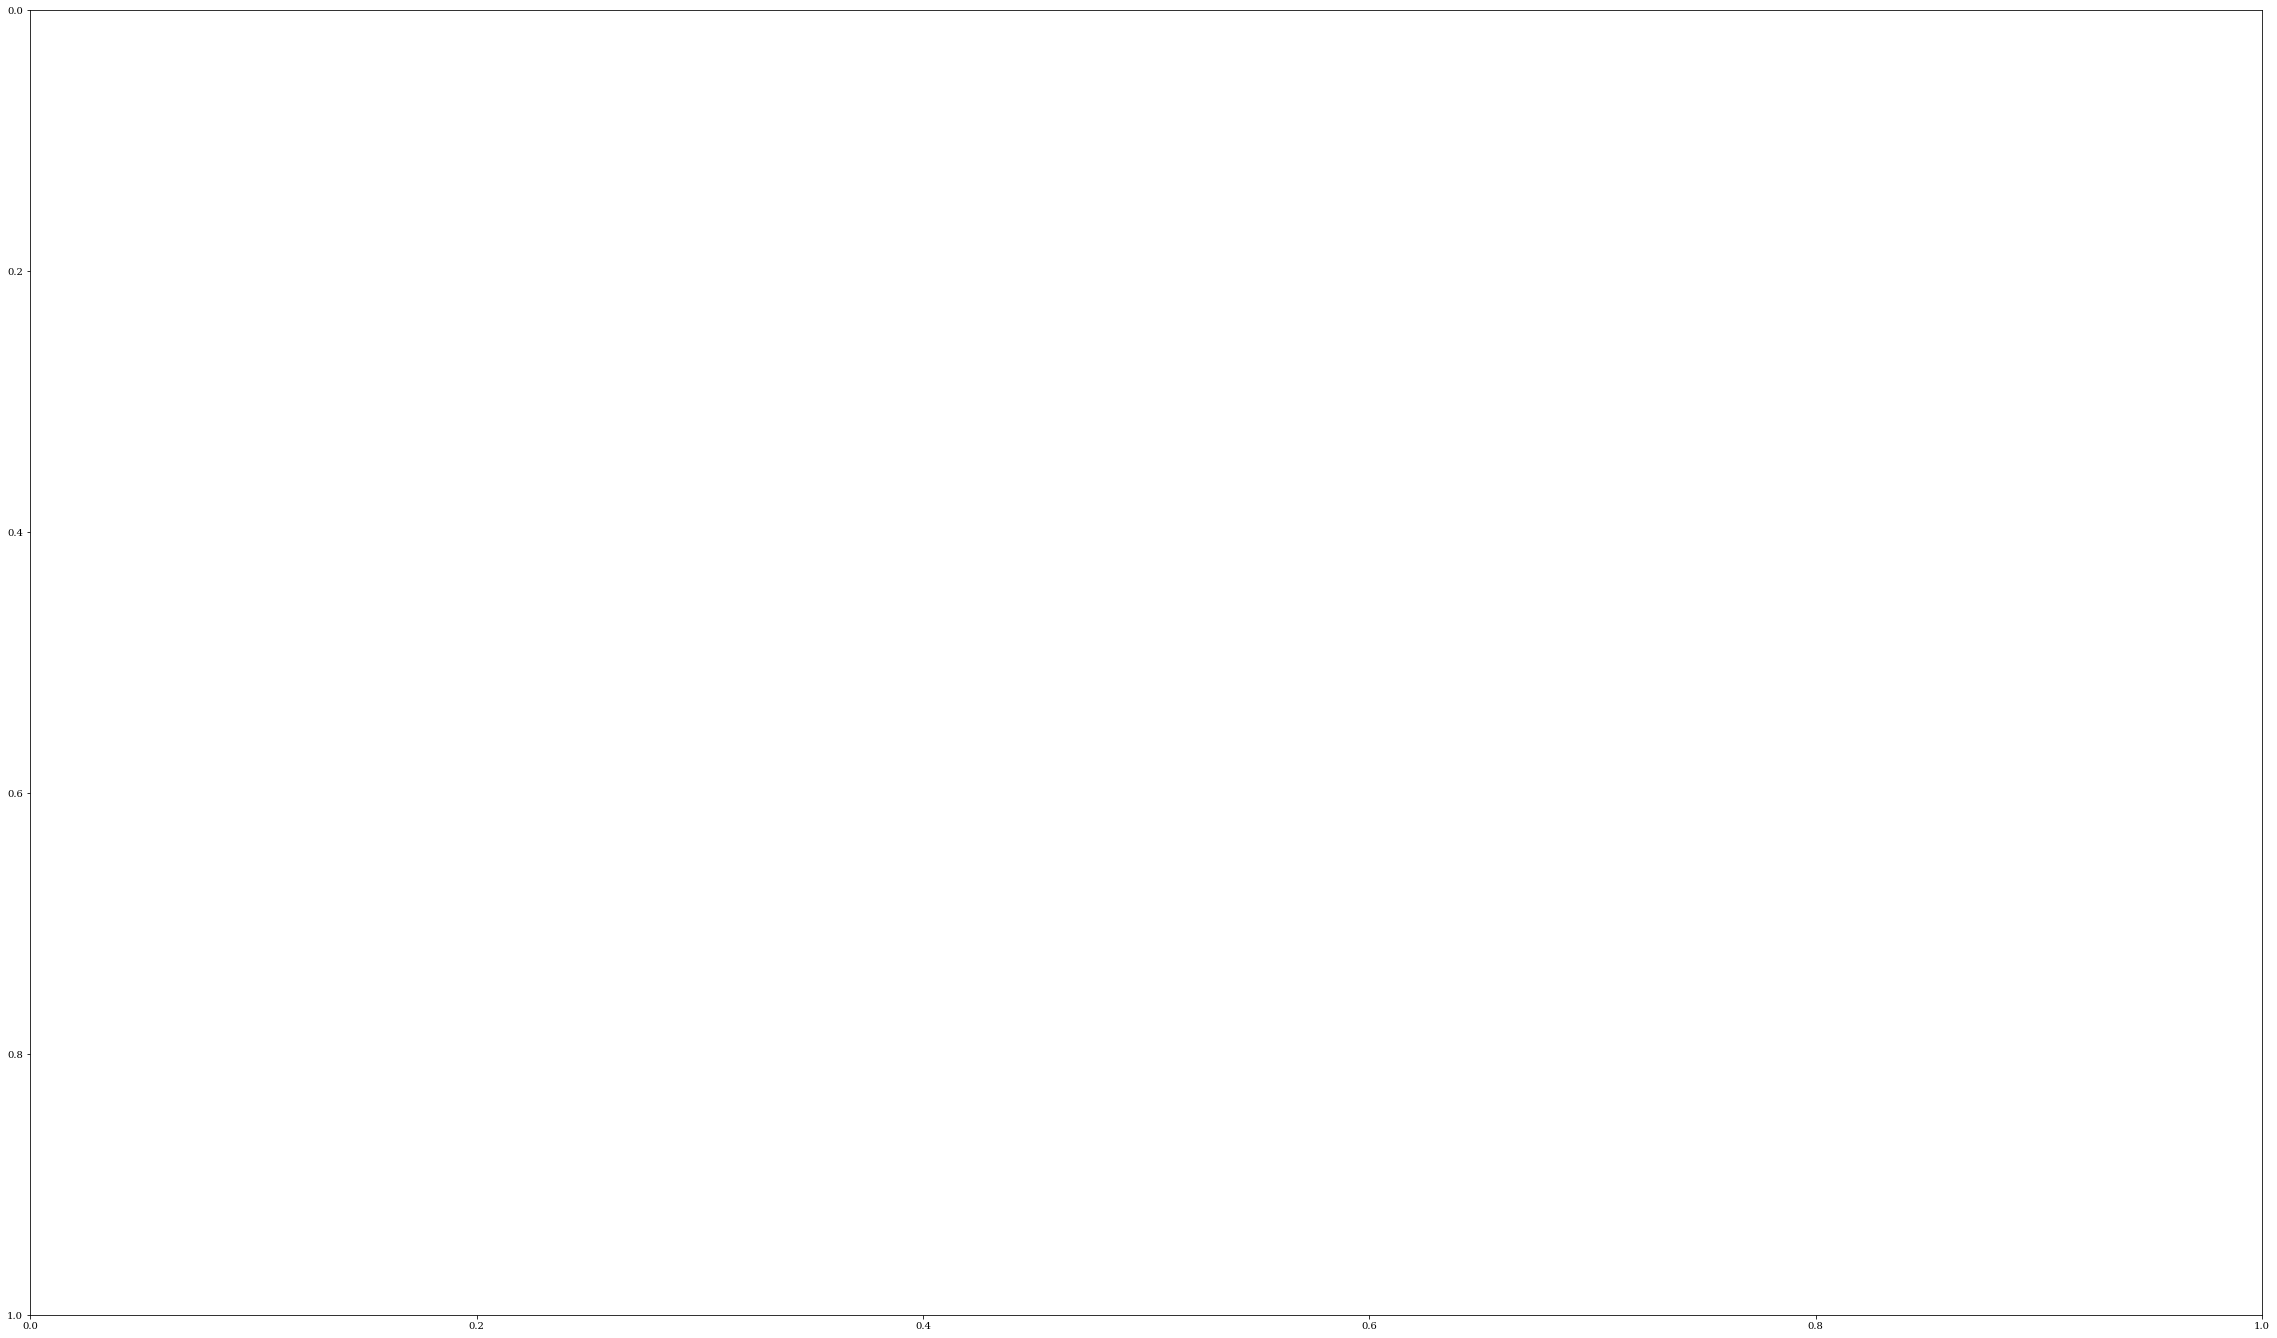

In [23]:
#30 TEST From STD DP
data_size = "5"
versions = ["2"]
it20 = [2000]
losses = ["p3standard0", "p4_ccombined_beta.5", "p5_flipcombined_beta.5"]
loss = losses[2]

std_preds = []
for v,version in enumerate(versions):
    for i,it in enumerate(it20):
        print(it,"it")
        if i == 0:
            it = "000" + str(it)
        config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"
        cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
        cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                             'DATATYPE', 'bee', \
                             'OUTPUT_DIR', 'training_dir/' + data_size + '/' + loss + '/'+ version + '/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                             'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/' + data_size + '/'+ loss +'/'+ version  +'/fcos_kps_ms_training_R_50_FPN_1x_bee/model_' +it +'.pth',\
                             'DATASETS.TEST', "('bee_val_cocostyle',)",\
                             'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                            ])
        coco_demo = COCODemo(
                    cfg,
                    min_image_size=800,
                    confidence_threshold=0.4,
        )


        #plt.figure(figsize = (20,12))
        mse_total = []
        for idx, image in enumerate(test_images[11:12]):
            mse_per_bee = []
            predictions, tps, hm_res, stride, hms, targets, c_loss = coco_demo.run_on_opencv_image(image)
            std_preds.append(predictions[:, :, [2, 1, 0]])
            plt.gca().invert_yaxis()

            

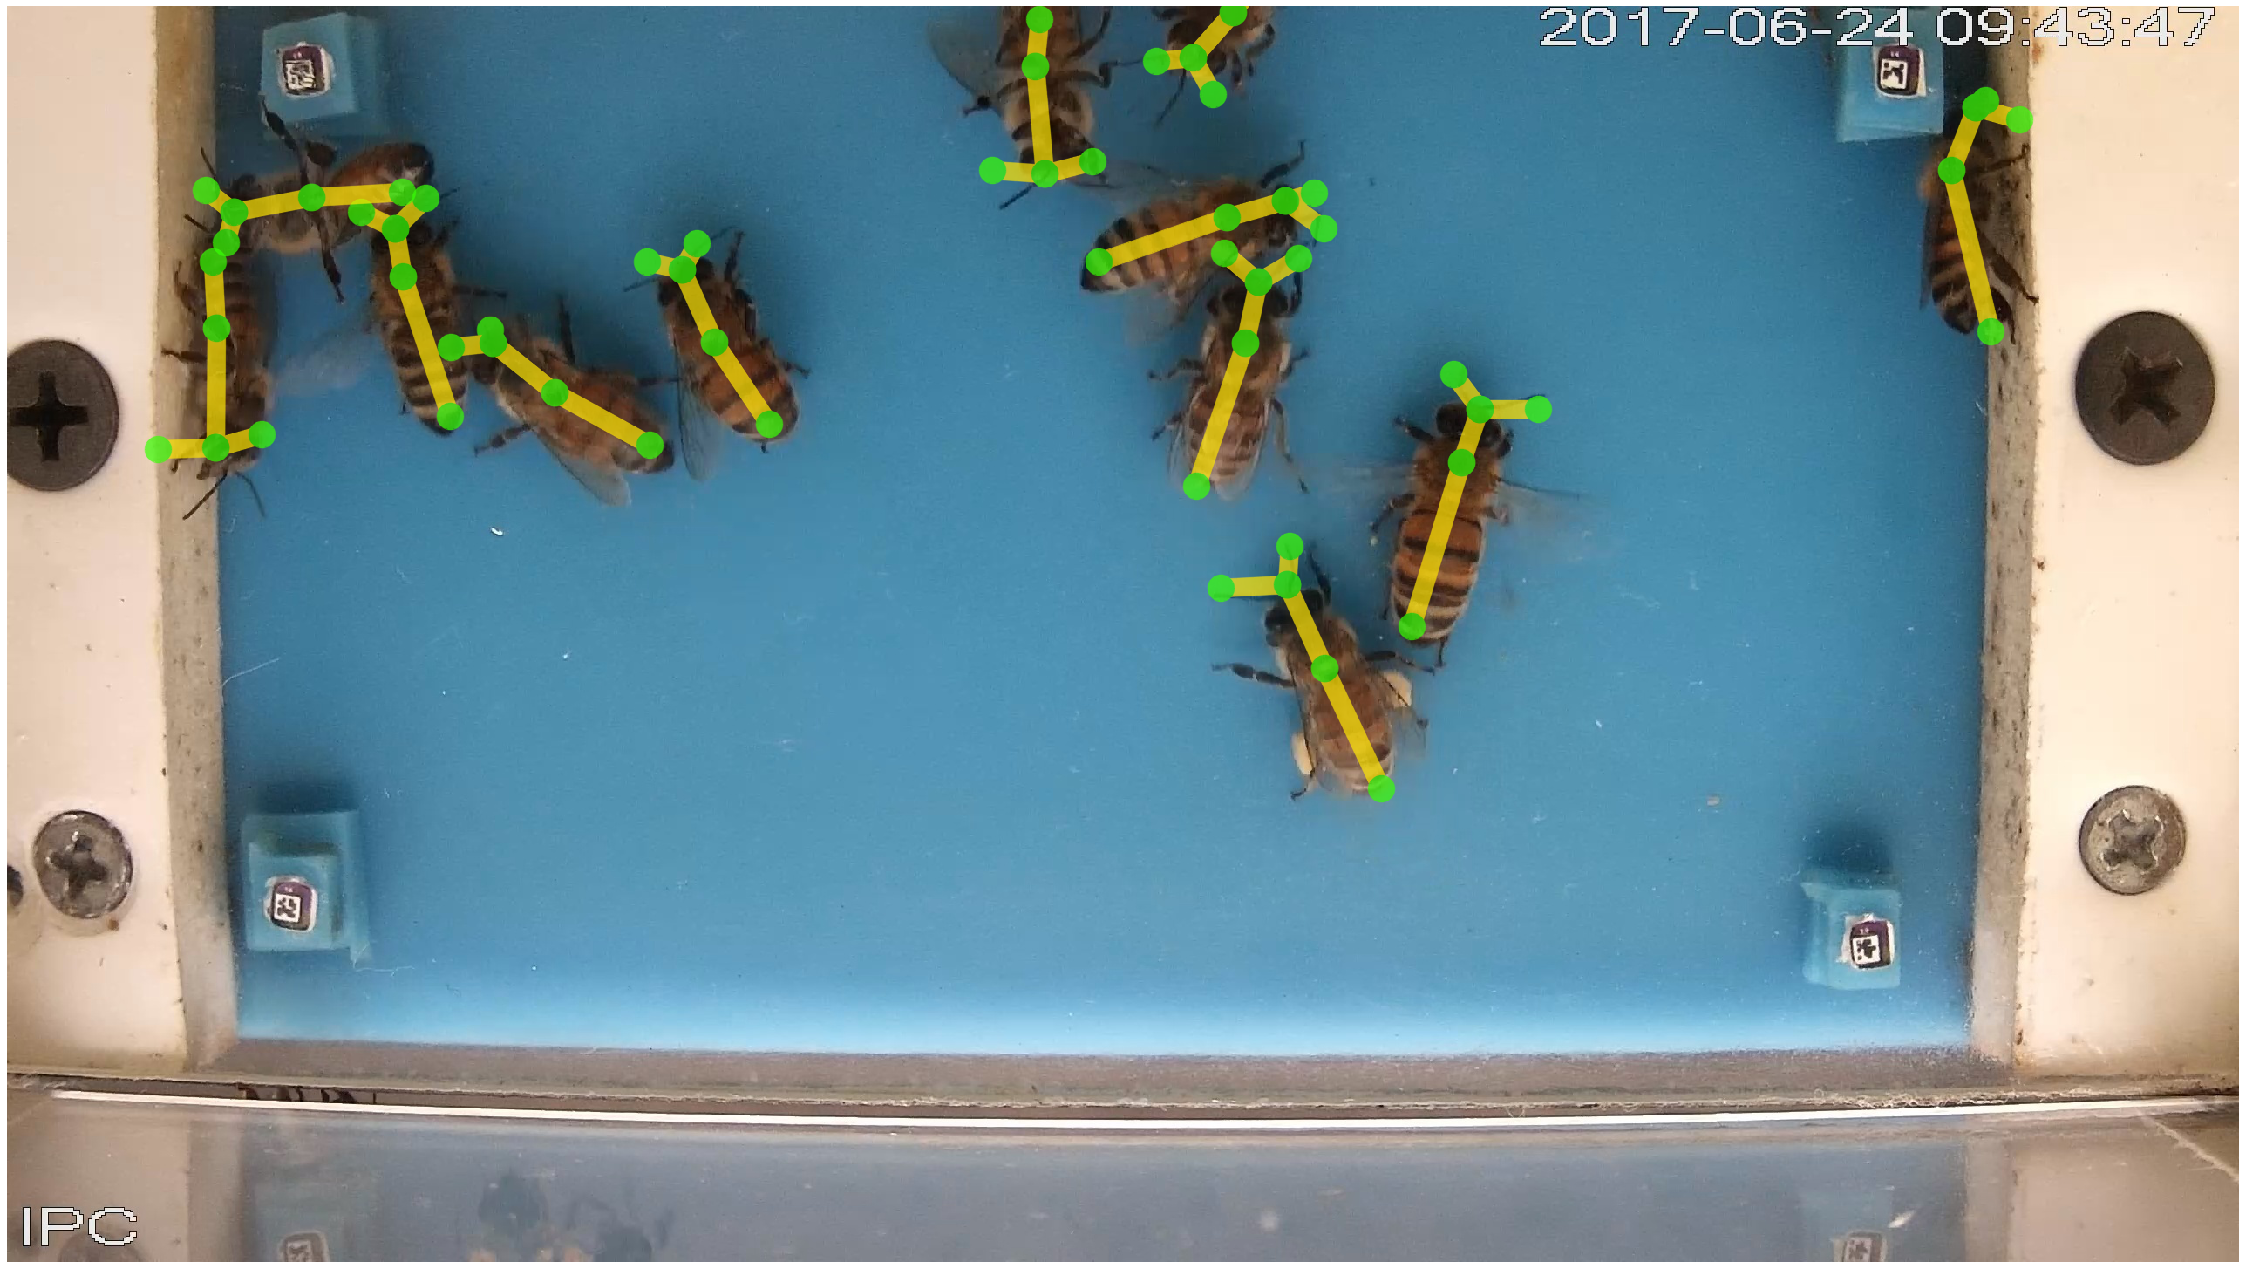

In [24]:
plt.imshow(std_preds[0])
plt.axis("off")
plt.gca().invert_yaxis()
plt.savefig('bee_new_unlabeled_5.png')

In [36]:
#sleap stuff
im = std_preds[0]
import h5py
filename = '../tools/sleap_topdown_5.slp'
with h5py.File(filename, 'r') as f:
    # List all groups
    #print('Keys: %s' % f.keys())
    a_group_key = list(f.keys())
    #print('a_group_key:', a_group_key)
    # Get the data
    frames = f['frames'][()]
    instances = f['instances'][()]
    points = f['points'][()]
    pred_points = f['pred_points'][()]
kps_bu = []#np.zeros((30))
for img_idx in range(0,30):
    if img_idx == 0:
        num_before = 0
        num_bees_per_img = frames[0][4]
    else:
        num_before = frames[(img_idx-1)][4]
        num_bees_per_img = frames[img_idx][4]-frames[img_idx][3]
    #print("nb", num_before)
    #print("num kps", int(num_bees_per_img*5))
    #print("range", int(num_before*5+num_bees_per_img*5) - int(num_before*5))
    #kps[img_idx] = np.zeros((num_bees_per_img,5,2))
    kps_bu.append(np.zeros((num_bees_per_img,5,2)))
    counter = 0
    current_idx = int(num_before*5)
    for pred_bee in range(0,num_bees_per_img):
        for kpt in range(0,5):
    #for point in pred_points[int(num_before*5):int(num_before*5+num_bees_per_img*5)]:
            #print("point", point)
            x = pred_points[current_idx][0]
            y = pred_points[current_idx][1]
            kps_bu[img_idx][pred_bee][kpt][0] = x
            kps_bu[img_idx][pred_bee][kpt][1] = y
            current_idx = current_idx + 1    
    

In [37]:
print(kps_bu[11][0])
im_bu = overlay_keypoints(test_images[11], kps_bu[11])

[[1357.23669434   62.67543411]
 [1369.65063477   98.62140656]
 [1393.06140137   14.62785244]
 [          nan           nan]
 [          nan           nan]]
color (40, 0, 255) lt 16
p1 (1357, 62) p2 (1393, 14)
color (0, 234, 255) lt 16
p1 (1393, 14) p2 (1369, 98)
color (0, 255, 0) lt 16
p1 (1369, 98) p2 nan
color (255, 235, 0) lt 16
p1 (1369, 98) p2 nan
color (40, 0, 255) lt 16
p1 (1178, -46) p2 (1178, 86)
color (0, 234, 255) lt 16
p1 (1178, 86) p2 (1178, 193)
color (0, 255, 0) lt 16
p1 (1178, 193) p2 (1142, 229)
color (255, 235, 0) lt 16
p1 (1178, 193) p2 (1202, 206)
color (40, 0, 255) lt 16
p1 (228, -34) p2 (240, 85)
color (0, 234, 255) lt 16
p1 (240, 85) p2 (205, 145)
color (0, 255, 0) lt 16
p1 (205, 145) p2 (193, 145)
color (255, 235, 0) lt 16
p1 (205, 145) p2 (241, 181)
color (40, 0, 255) lt 16
p1 (481, 181) p2 (397, 217)
color (0, 234, 255) lt 16
p1 (397, 217) p2 (289, 253)
color (0, 255, 0) lt 16
p1 (289, 253) p2 (265, 229)
color (255, 235, 0) lt 16
p1 (289, 253) p2 (289, 277)
co

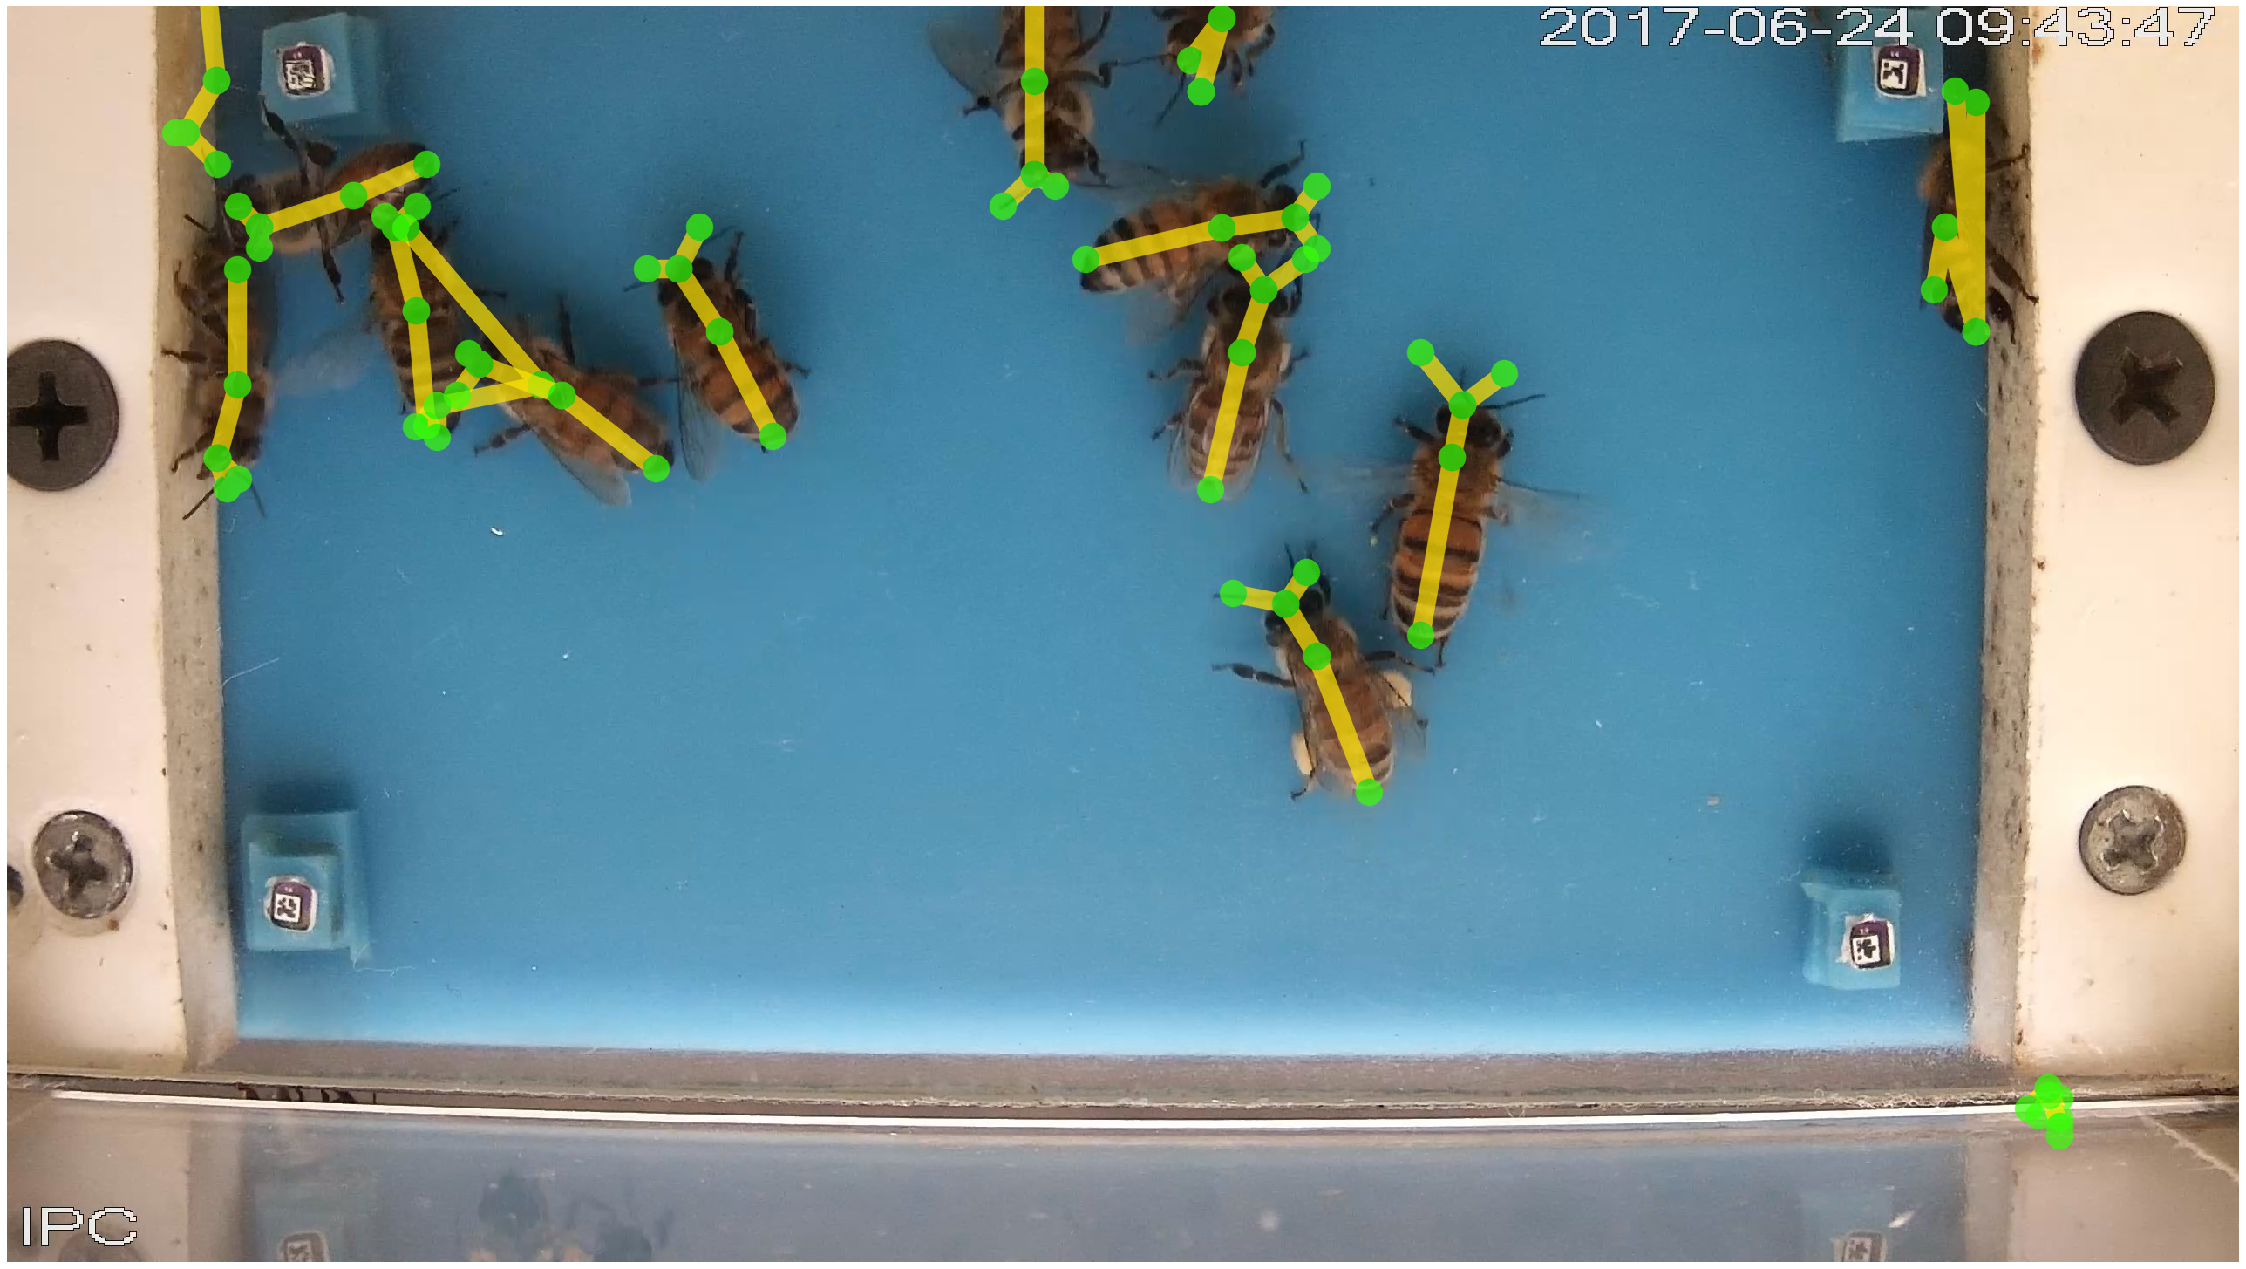

In [38]:
imshow(im_bu)
plt.axis("off")
plt.gca().invert_yaxis()
plt.savefig('bee_new_topdown_5.png')

In [9]:
frame_index = None

test_std_preds
test_f25_preds
#test_f5_preds

save_file = 'bee_comapre_tests_small.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
img0 = np.concatenate((test_std_preds[0], test_f25_preds[0]), axis=1)
dd1,dd2 = (img0.shape[0]),(img0.shape[1])
print(dd1,dd2)
out = cv2.VideoWriter(save_file, fourcc, 1.0, (dd2,dd1))
#out_f25 = cv2.VideoWriter(save_file, fourcc, .20, (dd2,dd1))
#out_f5 = cv2.VideoWriter(save_file, fourcc, .20, (dd2,dd1))
for (imstd, imf25) in zip(test_std_preds,test_f25_preds):
    img_A = np.array(imstd)
    img_B = np.array(imf25)
    #img_C = np.array(imf5)

    plot_image = np.concatenate((img_A, img_B), axis=1)

    #plt.imshow(plot_image)
    #plt.show()
    out.write(plot_image)#.astype(np.uint8))
    #out_f25.write(inf25.astype(np.uint8))
    #out_f5.write(imf5.astype(np.uint8))
    
out.release()


NameError: name 'test_std_preds' is not defined